Importing the Labs

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

from typing import Tuple
import numpy as np

import unittest
from functools import partial

Defining The CNN

In [2]:
def get_conv_weight_and_bias(
        filter_size: Tuple[int, int],
        num_groups: int,
        input_channels: int,
        output_channels: int,
        bias: bool
) -> Tuple[torch.Tensor, torch.Tensor]:
    # assert that num_filters is divisible by num_groups
    assert input_channels % num_groups == 0, "input channels must be divisible by groups number"
    # assert that num_channels is divisible by num_groups
    assert output_channels % num_groups == 0, "output channels must be divisible by groups number"
    input_channels = input_channels // num_groups

    # initialize the weight matrix
    weight_matrix = torch.randn(output_channels, input_channels, *filter_size)
    # initialize the bias vector
    if bias:
        bias_vector = torch.ones(output_channels)
    else:
        bias_vector = None
    return weight_matrix, bias_vector


class MyConvStub:
    def __init__(
            self,
            kernel_size: Tuple[int, int],
            num_groups: int,
            input_channels: int,
            output_channels: int,
            bias: bool,
            stride: int,
            dilation: int,
    ):
        self.weight, self.bias = get_conv_weight_and_bias(kernel_size, num_groups, input_channels, output_channels, bias)
        self.groups = num_groups
        self.stride = stride
        self.dilation = dilation
        self.kernel_size = kernel_size #

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, in_c, in_h, in_w = x.shape
        out_c, in_c_per_group, kH, kW = self.weight.shape

        # 1. Calculate Output Dimensions (Padding is 0 per test script)
        out_h = (in_h - self.dilation * (kH - 1) - 1) // self.stride + 1
        out_w = (in_w - self.dilation * (kW - 1) - 1) // self.stride + 1

        # 2. Unfold: Transform image patches into columns
        # Shape: (batch, in_c * kH * kW, L) where L = out_h * out_w
        x_unfolded = F.unfold(x, self.kernel_size, dilation=self.dilation, stride=self.stride, padding=0)

        # 3. Reshape for Grouped Matrix Multiplication
        # Input: (batch, groups, in_c_per_group * kH * kW, L)
        x_unfolded = x_unfolded.view(batch_size, self.groups, -1, x_unfolded.shape[-1])

        # Weight: (groups, out_c_per_group, in_c_per_group * kH * kW)
        w_reshaped = self.weight.view(self.groups, out_c // self.groups, -1)

        # 4. Batch Matrix Multiplication
        # Result: (batch, groups, out_c_per_group, L)
        out = torch.matmul(w_reshaped, x_unfolded)

        # 5. Reshape to image output: (batch, out_c, out_h, out_w)
        out = out.view(batch_size, out_c, out_h, out_w)

        # 6. Add Bias
        if self.bias is not None:
            out += self.bias.view(1, -1, 1, 1)

        return out


class MyFilterStub:
    def __init__(
            self,
            filter: torch.Tensor,
            input_channels: int,
    ):
        self.weight = filter
        self.input_channels = input_channels

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Each channel is blurred independently using the same filter (Depthwise Conv)
        kH, kW = self.weight.shape

        # Reshape the single 2D filter to (input_channels, 1, kH, kW)
        expanded_weight = self.weight.expand(self.input_channels, 1, kH, kW)

        # Apply convolution with groups = input_channels
        # padding=0 to match the test script's Filter2D implementation
        return F.conv2d(x, expanded_weight, stride=1, padding=0, groups=self.input_channels)

Blur Kernel

In [3]:

def get_blur_kernel(size: int, ) -> torch.Tensor:
    def blur_values(size: int = 4) -> torch.Tensor:
        if size == 1:
            k = torch.tensor([1., ], dtype=torch.float32)
        elif size == 2:
            k = torch.tensor([1., 1.], dtype=torch.float32)
        elif size == 3:
            k = torch.tensor([1., 2., 1.], dtype=torch.float32)
        elif size == 4:
            k = torch.tensor([1., 3., 3., 1.], dtype=torch.float32)
        elif size == 5:
            k = torch.tensor([1., 4., 6., 4., 1.], dtype=torch.float32)
        elif size == 6:
            k = torch.tensor([1., 5., 10., 10., 5., 1.], dtype=torch.float32)
        elif size == 7:
            k = torch.tensor([1., 6., 15., 20., 15., 6., 1.], dtype=torch.float32)
        return k

    def make_kernel_from_values(k: torch.Tensor) -> torch.Tensor:
        if k.ndim == 1:
            k = k[None, :] * k[:, None]

        k /= k.sum()

        return k

    k = blur_values(size)
    k = make_kernel_from_values(k)
    return k

CNN Test

In [4]:

kernel_size_stub_constructor = partial(MyConvStub, input_channels=128, output_channels=128, num_groups=1, stride=1, dilation=1, bias=False)
filter_size_stub_constructor = partial(MyConvStub, kernel_size=(3, 3), num_groups=1, stride=1, dilation=1, bias=False)
biased_filter_size_stub_constructor = partial(MyConvStub, kernel_size=(3, 3), num_groups=1, stride=1, dilation=1, bias=True)
stride_size_stub_constructor = partial(MyConvStub, input_channels=128, output_channels=128, kernel_size=(3, 3), num_groups=1, dilation=1, bias=False)
dilation_size_stub_constructor = partial(MyConvStub, input_channels=128, output_channels=128, kernel_size=(3, 3), num_groups=1, stride=1, bias=False)
groups_size_stub_constructor = partial(MyConvStub, input_channels=128, output_channels=256, kernel_size=(3, 3), stride=1, dilation=1, bias=False)


ATOL = 1e-3

class ConvTests(unittest.TestCase):
    """A suite of test that performs numerical checking on ConvStub"""
    def test_square_kernels(self):
        kernel_sizes = [(k, k) for k in range(1, 8)]
        for kernel_size in kernel_sizes:
            # create a conv stub
            conv = kernel_size_stub_constructor(kernel_size=kernel_size)
            random_input = torch.randn(4, 128, 64, 64)

            output = conv.forward(random_input)
            test_output = F.conv2d(
                input=random_input,
                weight=conv.weight,
                groups=conv.groups,
                stride=conv.stride,
                dilation=conv.dilation,
                padding=0,
            )

            self.assertTrue(torch.allclose(output, test_output, atol=ATOL))

    def test_horizontal_kernel(self):
        kernel_sizes = [(k, k + 2) for k in range(1, 8)]
        for kernel_size in kernel_sizes:
            # create a conv stub
            conv = kernel_size_stub_constructor(kernel_size=kernel_size)
            random_input = torch.randn(4, 128, 64, 64)

            output = conv.forward(random_input)
            test_output = F.conv2d(
                input=random_input,
                weight=conv.weight,
                groups=conv.groups,
                stride=conv.stride,
                dilation=conv.dilation,
                padding=0,
            )

            self.assertTrue(torch.allclose(output, test_output, atol=ATOL))

    def test_vertical_kernel(self):
        kernel_sizes = [(k + 2, k) for k in range(1, 8)]
        for kernel_size in kernel_sizes:
            # create a conv stub
            conv = kernel_size_stub_constructor(kernel_size=kernel_size)
            random_input = torch.randn(4, 128, 64, 64)

            output = conv.forward(random_input)
            test_output = F.conv2d(
                input=random_input,
                weight=conv.weight,
                groups=conv.groups,
                stride=conv.stride,
                dilation=conv.dilation,
                padding=0,
            )

            self.assertTrue(torch.allclose(output, test_output, atol=ATOL))

    def test_increasing_filter_sizes(self):
        input_sizes = [(2 ** i) for i in range(0, 8)]
        output_sizes = [(3 ** i) for i in range(1, 6)]
        for input_size, output_size in zip(input_sizes, output_sizes):
            # create a conv stub
            conv = filter_size_stub_constructor(input_channels=input_size, output_channels=output_size)
            random_input = torch.randn(4, input_size, 64, 64)

            output = conv.forward(random_input)
            test_output = F.conv2d(
                input=random_input,
                weight=conv.weight,
                groups=conv.groups,
                stride=conv.stride,
                dilation=conv.dilation,
                padding=0,
            )

            self.assertTrue(torch.allclose(output, test_output, atol=ATOL))

    def test_decreasing_filter_sizes(self):
        output_sizes = [(2 ** i) for i in range(0, 8)]
        input_sizes = [(3 ** i) for i in range(1, 6)]
        for input_size, output_size in zip(input_sizes, output_sizes):
            # create a conv stub
            conv = filter_size_stub_constructor(input_channels=input_size, output_channels=output_size)
            random_input = torch.randn(4, input_size, 64, 64)

            output = conv.forward(random_input)
            test_output = F.conv2d(
                input=random_input,
                weight=conv.weight,
                groups=conv.groups,
                stride=conv.stride,
                dilation=conv.dilation,
                padding=0,
            )

            self.assertTrue(torch.allclose(output, test_output, atol=ATOL))

    def test_same_number_of_filters(self):
        input_sizes = [(2 ** i) for i in range(0, 8)]
        output_sizes = [(2 ** i) for i in range(0, 8)]
        for input_size, output_size in zip(input_sizes, output_sizes):
            # create a conv stub
            conv = filter_size_stub_constructor(input_channels=input_size, output_channels=output_size)
            random_input = torch.randn(4, input_size, 64, 64)

            output = conv.forward(random_input)
            test_output = F.conv2d(
                input=random_input,
                weight=conv.weight,
                groups=conv.groups,
                stride=conv.stride,
                dilation=conv.dilation,
                padding=0,
            )

            self.assertTrue(torch.allclose(output, test_output, atol=ATOL))

    def test_stride(self):
        strides = list(range(1, 4))
        for stride in strides:
            # create a conv stub
            conv = stride_size_stub_constructor(stride=stride)
            random_input = torch.randn(4, 128, 64, 64)

            output = conv.forward(random_input)
            test_output = F.conv2d(
                input=random_input,
                weight=conv.weight,
                groups=conv.groups,
                stride=conv.stride,
                dilation=conv.dilation,
                padding=0
            )

            self.assertTrue(torch.allclose(output, test_output, atol=ATOL))

    def test_dilation(self):
        dilations = list(range(1, 4))
        for dilation in dilations:
            # create a conv stub
            conv = dilation_size_stub_constructor(dilation=dilation)
            random_input = torch.randn(4, 128, 64, 64)

            output = conv.forward(random_input)
            test_output = F.conv2d(
                input=random_input,
                weight=conv.weight,
                groups=conv.groups,
                stride=conv.stride,
                dilation=conv.dilation,
                padding=0
            )

            self.assertTrue(torch.allclose(output, test_output, atol=ATOL))

    def test_grouping(self):
        groups = [4, 8, 16, 32, 64]
        for group in groups:
            # create a conv stub
            conv = groups_size_stub_constructor(num_groups=group)
            random_input = torch.randn(4, 128, 64, 64)

            output = conv.forward(random_input)
            test_output = F.conv2d(
                input=random_input,
                weight=conv.weight,
                groups=conv.groups,
                stride=conv.stride,
                dilation=conv.dilation,
                padding=0
            )

            self.assertTrue(torch.allclose(output, test_output, atol=ATOL))

    def test_biased_conv(self):
        input_sizes = [(2 ** i) for i in range(0, 8)]
        output_sizes = [(3 ** i) for i in range(1, 6)]
        for input_size, output_size in zip(input_sizes, output_sizes):
            # create a conv stub
            conv = biased_filter_size_stub_constructor(input_channels=input_size, output_channels=output_size)
            random_input = torch.randn(4, input_size, 64, 64)

            output = conv.forward(random_input)
            test_output = F.conv2d(
                input=random_input,
                weight=conv.weight,
                groups=conv.groups,
                stride=conv.stride,
                dilation=conv.dilation,
                bias=conv.bias,
                padding=0,
            )

            self.assertTrue(torch.allclose(output, test_output, atol=ATOL))

    def test_zero_biased_conv(self):
        input_sizes = [(2 ** i) for i in range(0, 8)]
        output_sizes = [(3 ** i) for i in range(1, 6)]
        for input_size, output_size in zip(input_sizes, output_sizes):
            # create a conv stub
            conv = filter_size_stub_constructor(input_channels=input_size, output_channels=output_size)
            random_input = torch.randn(4, input_size, 64, 64)

            output = conv.forward(random_input)
            test_output = F.conv2d(
                input=random_input,
                weight=conv.weight,
                groups=conv.groups,
                stride=conv.stride,
                dilation=conv.dilation,
                bias=torch.zeros(output_size),
                padding=0,
            )

            self.assertTrue(torch.allclose(output, test_output, atol=ATOL))




class FilterTest(unittest.TestCase):
    """A suite of tests that numerically checks the filtering operation"""

    class Filter2D(nn.Module):
        def __init__(self, channels: int, kernel: torch.Tensor):
            super().__init__()
            self.register_buffer('filter', kernel[None, None, :, :].repeat(channels, 1, 1, 1))

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            b, c, h, w = x.shape
            return F.conv2d(
                x,
                self.filter,
                stride=1,
                padding=0,
                groups=c,
            )

    def test_filter(self):
        blur_sizes = list(range(1, 7))
        for blur_size in blur_sizes:
            # create a filter stub
            blur_kernel = get_blur_kernel(blur_size)
            conv = MyFilterStub(filter=blur_kernel, input_channels=128)
            test_conv = self.Filter2D(128, blur_kernel)
            random_input = torch.randn(4, 128, 64, 64)
            output = conv.forward(random_input)
            test_output = test_conv.forward(random_input)

            self.assertTrue(torch.allclose(output, test_output, atol=ATOL))



Test Runner

In [5]:
import sys

def run_all_tests():
    # 1. Create a test suite
    suite = unittest.TestSuite()

    # 2. Add your test classes to the suite
    suite.addTest(unittest.makeSuite(ConvTests))
    suite.addTest(unittest.makeSuite(FilterTest))

    # 3. Run the tests and show output in the cell
    runner = unittest.TextTestRunner(stream=sys.stdout, verbosity=2)
    runner.run(suite)

run_all_tests()

test_biased_conv (__main__.ConvTests.test_biased_conv) ... 

/tmp/ipython-input-4127024692.py:8: DeprecationWarning: unittest.makeSuite() is deprecated and will be removed in Python 3.13. Please use unittest.TestLoader.loadTestsFromTestCase() instead.
  suite.addTest(unittest.makeSuite(ConvTests))
/tmp/ipython-input-4127024692.py:9: DeprecationWarning: unittest.makeSuite() is deprecated and will be removed in Python 3.13. Please use unittest.TestLoader.loadTestsFromTestCase() instead.
  suite.addTest(unittest.makeSuite(FilterTest))


ok
test_decreasing_filter_sizes (__main__.ConvTests.test_decreasing_filter_sizes) ... ok
test_dilation (__main__.ConvTests.test_dilation) ... ok
test_grouping (__main__.ConvTests.test_grouping) ... ok
test_horizontal_kernel (__main__.ConvTests.test_horizontal_kernel) ... ok
test_increasing_filter_sizes (__main__.ConvTests.test_increasing_filter_sizes) ... ok
test_same_number_of_filters (__main__.ConvTests.test_same_number_of_filters) ... ok
test_square_kernels (__main__.ConvTests.test_square_kernels) ... ok
test_stride (__main__.ConvTests.test_stride) ... ok
test_vertical_kernel (__main__.ConvTests.test_vertical_kernel) ... ok
test_zero_biased_conv (__main__.ConvTests.test_zero_biased_conv) ... ok
test_filter (__main__.FilterTest.test_filter) ... ok

----------------------------------------------------------------------
Ran 12 tests in 13.660s

OK


# Task 2

importing Libs

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os


Getting Data

In [7]:
# --- 1. Dataset Setup ---
def get_loaders(use_aug=False):
    # Imagenet normalization stats
    stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

    # Base transforms
    base_tfms = [transforms.Resize((160, 160)), transforms.ToTensor(), transforms.Normalize(*stats)]

    # Augmentation transforms (Task requirement: specify in report)
    aug_tfms = [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomRotation(10)
    ] + base_tfms if use_aug else base_tfms

    train_ds = datasets.Imagenette(root='./data', split='train', size='160px', download=True,
                                  transform=transforms.Compose(aug_tfms))
    test_ds = datasets.Imagenette(root='./data', split='val', size='160px', download=True,
                                 transform=transforms.Compose(base_tfms))

    return DataLoader(train_ds, batch_size=64, shuffle=True), DataLoader(test_ds, batch_size=64)

Creating the model

In [8]:
import torch.nn as nn

# --- 2. Configurable 5-Layer Model ---
class ImagenetteModel(nn.Module):
    def __init__(self, use_bn=False, dropout_p=0.0):
        super().__init__()
        self.use_bn = use_bn
        # 3 Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if use_bn else nn.Identity()

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) if use_bn else nn.Identity()

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) if use_bn else nn.Identity()

        self.pool = nn.MaxPool2d(2, 2)

        # 2 Linear Layers
        # 160 -> 80 -> 40 -> 20 (after 3 pools)
        self.fc1 = nn.Linear(128 * 20 * 20, 256)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

Train

In [10]:
def train_model(model, train_loader, test_loader, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    stats = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            correct += (output.argmax(1) == labels).type(torch.float).sum().item()

        # Validation
        model.eval()
        test_loss, test_correct = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                test_loss += criterion(output, labels).item()
                test_correct += (output.argmax(1) == labels).type(torch.float).sum().item()

        stats['train_loss'].append(train_loss/len(train_loader))
        stats['test_loss'].append(test_loss/len(test_loader))
        stats['train_acc'].append(correct/len(train_loader.dataset))
        stats['test_acc'].append(test_correct/len(test_loader.dataset))

        print(f"Epoch {epoch+1}/{epochs} - Test Acc: {stats['test_acc'][-1]:.4f}")

    return stats

Testing


>>> Running Experiment: Baseline
Epoch 1/20 - Test Acc: 0.5251
Epoch 2/20 - Test Acc: 0.5918
Epoch 3/20 - Test Acc: 0.6341
Epoch 4/20 - Test Acc: 0.6329
Epoch 5/20 - Test Acc: 0.6448
Epoch 6/20 - Test Acc: 0.6436
Epoch 7/20 - Test Acc: 0.6234
Epoch 8/20 - Test Acc: 0.6316
Epoch 9/20 - Test Acc: 0.6324
Epoch 10/20 - Test Acc: 0.6311
Epoch 11/20 - Test Acc: 0.6211
Epoch 12/20 - Test Acc: 0.6336
Epoch 13/20 - Test Acc: 0.6316
Epoch 14/20 - Test Acc: 0.6318
Epoch 15/20 - Test Acc: 0.6301
Epoch 16/20 - Test Acc: 0.6176
Epoch 17/20 - Test Acc: 0.6227
Epoch 18/20 - Test Acc: 0.6318
Epoch 19/20 - Test Acc: 0.6367
Epoch 20/20 - Test Acc: 0.6041

>>> Running Experiment: Batch Normalization
Epoch 1/20 - Test Acc: 0.5164
Epoch 2/20 - Test Acc: 0.5646
Epoch 3/20 - Test Acc: 0.6239
Epoch 4/20 - Test Acc: 0.6191
Epoch 5/20 - Test Acc: 0.6331
Epoch 6/20 - Test Acc: 0.6604
Epoch 7/20 - Test Acc: 0.6772
Epoch 8/20 - Test Acc: 0.6828
Epoch 9/20 - Test Acc: 0.6499
Epoch 10/20 - Test Acc: 0.6701
Epoch 11/

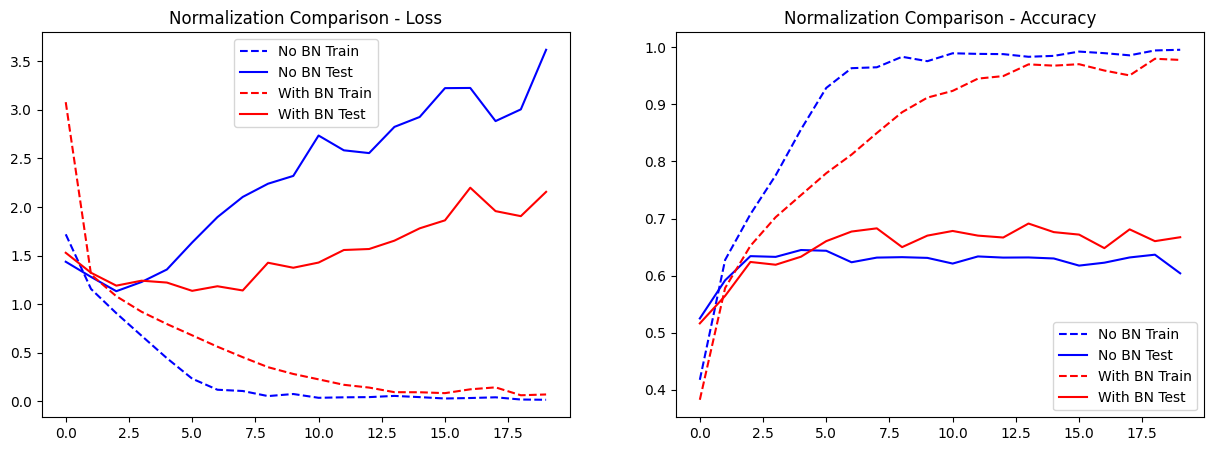

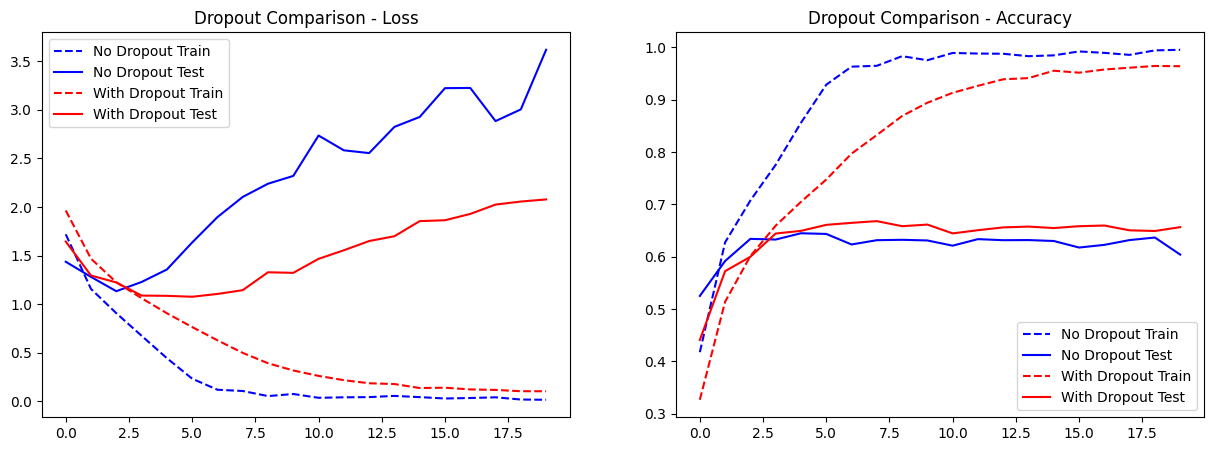

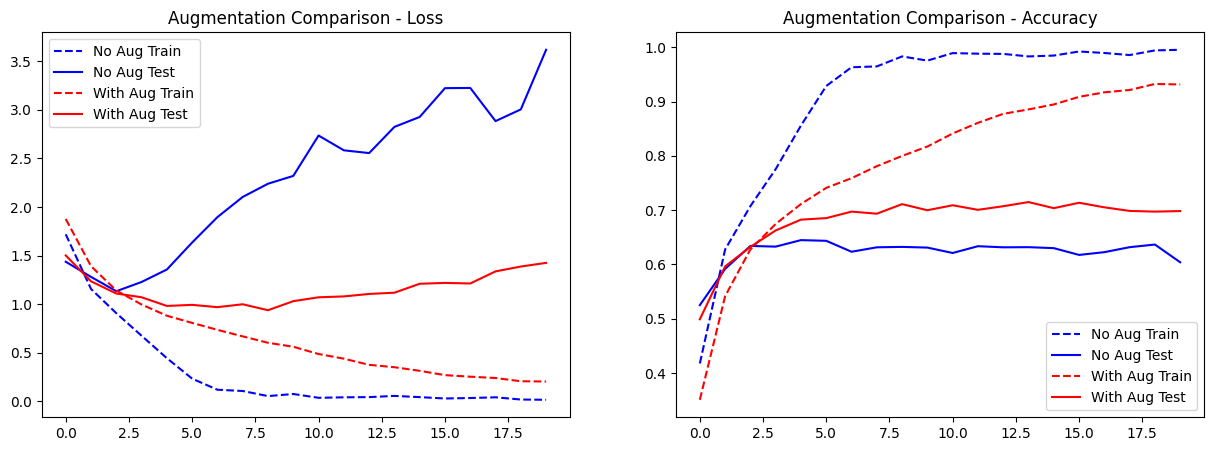

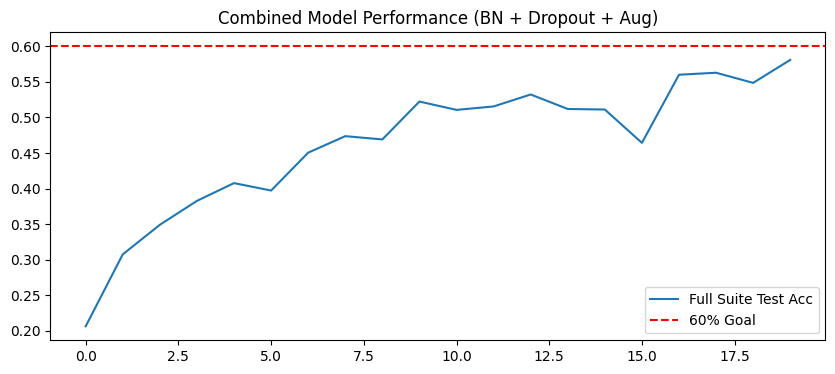

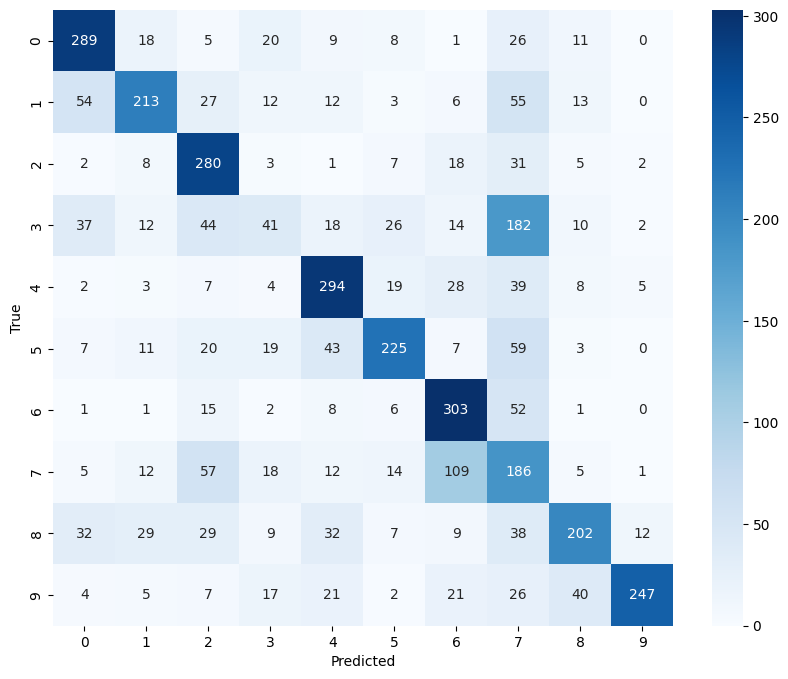

In [14]:
import torch.optim as optim

# Helper to run an experiment and store results
def run_experiment(name, use_bn=False, dropout=0.0, use_aug=False):
    print(f"\n>>> Running Experiment: {name}")
    train_loader, test_loader = get_loaders(use_aug=use_aug)
    model = ImagenetteModel(use_bn=use_bn, dropout_p=dropout)
    stats = train_model(model, train_loader, test_loader, epochs=20)
    return stats, model

def plot_confusion_matrix(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()




# 1. Baseline
stats_base, _ = run_experiment("Baseline", use_bn=False, dropout=0.0, use_aug=False)

# 2. Batch Normalization
stats_bn, _ = run_experiment("Batch Normalization", use_bn=True, dropout=0.0, use_aug=False)

# 3. Dropout
stats_drop, _ = run_experiment("Dropout", use_bn=False, dropout=0.5, use_aug=False)

# 4. Data Augmentation
stats_aug, _ = run_experiment("Augmentation", use_bn=False, dropout=0.0, use_aug=True)

# 5. Full Suite (BN + Dropout + Augmentation)
stats_full, model_full = run_experiment("Full Suite", use_bn=True, dropout=0.5, use_aug=True)

# --- Plotting the 4 Required Comparison Graphs ---
def plot_comparison(stats1, stats2, label1, label2, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curves
    ax1.plot(stats1['train_loss'], '--', color='blue', label=f'{label1} Train')
    ax1.plot(stats1['test_loss'], '-', color='blue', label=f'{label1} Test')
    ax1.plot(stats2['train_loss'], '--', color='red', label=f'{label2} Train')
    ax1.plot(stats2['test_loss'], '-', color='red', label=f'{label2} Test')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()

    # Accuracy curves
    ax2.plot(stats1['train_acc'], '--', color='blue', label=f'{label1} Train')
    ax2.plot(stats1['test_acc'], '-', color='blue', label=f'{label1} Test')
    ax2.plot(stats2['train_acc'], '--', color='red', label=f'{label2} Train')
    ax2.plot(stats2['test_acc'], '-', color='red', label=f'{label2} Test')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    plt.show()

# Generate the Plots for the report
plot_comparison(stats_base, stats_bn, "No BN", "With BN", "Normalization Comparison")
plot_comparison(stats_base, stats_drop, "No Dropout", "With Dropout", "Dropout Comparison")
plot_comparison(stats_base, stats_aug, "No Aug", "With Aug", "Augmentation Comparison")

# Plot results for the full suite
plt.figure(figsize=(10,4))
plt.plot(stats_full['test_acc'], label="Full Suite Test Acc")
plt.axhline(y=0.6, color='r', linestyle='--', label="60% Goal")
plt.title("Combined Model Performance (BN + Dropout + Aug)")
plt.legend(); plt.show()

# Final Confusion Matrix
plot_confusion_matrix(model_full, test_loader)

# Task 3

Importing

In [15]:
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim

Load resNet

In [16]:
def get_resnet_experiment(unfreeze_bn=False):
    # 1. Load pre-trained ResNet-18
    # Using weights=models.ResNet18_Weights.IMAGENET1K_V1 for current torchvision versions
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # 2. Freeze all parameters first
    for param in model.parameters():
        param.requires_grad = False

    # 3. Handle BatchNormalization unfreezing
    if unfreeze_bn:
        for module in model.modules():
            if isinstance(module, nn.BatchNorm2d):
                for param in module.parameters():
                    param.requires_grad = True
                module.train() # Set to train mode to update running stats

    # 4. Replace the final fully connected layer (ResNet-18 ends in 512 units)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)

    return model

Run tests

In [17]:
train_loader, test_loader = get_loaders(use_aug=True)

print(">>> Training ResNet-18: Standard Feature Extractor")
model_resnet_frozen = get_resnet_experiment(unfreeze_bn=False)
stats_resnet_frozen = train_model(model_resnet_frozen, train_loader, test_loader, epochs=10) # ResNet converges fast

print("\n>>> Training ResNet-18: With Unfrozen BN Layers")
model_resnet_unfrozen_bn = get_resnet_experiment(unfreeze_bn=True)
stats_resnet_unfrozen_bn = train_model(model_resnet_unfrozen_bn, train_loader, test_loader, epochs=10)

>>> Training ResNet-18: Standard Feature Extractor
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


Epoch 1/10 - Test Acc: 0.9261
Epoch 2/10 - Test Acc: 0.9340
Epoch 3/10 - Test Acc: 0.9383
Epoch 4/10 - Test Acc: 0.9406
Epoch 5/10 - Test Acc: 0.9445
Epoch 6/10 - Test Acc: 0.9399
Epoch 7/10 - Test Acc: 0.9457
Epoch 8/10 - Test Acc: 0.9445
Epoch 9/10 - Test Acc: 0.9455
Epoch 10/10 - Test Acc: 0.9447

>>> Training ResNet-18: With Unfrozen BN Layers
Epoch 1/10 - Test Acc: 0.9411
Epoch 2/10 - Test Acc: 0.9564
Epoch 3/10 - Test Acc: 0.9587
Epoch 4/10 - Test Acc: 0.9597
Epoch 5/10 - Test Acc: 0.9582
Epoch 6/10 - Test Acc: 0.9608
Epoch 7/10 - Test Acc: 0.9623
Epoch 8/10 - Test Acc: 0.9580
Epoch 9/10 - Test Acc: 0.9610
Epoch 10/10 - Test Acc: 0.9603


Visualization

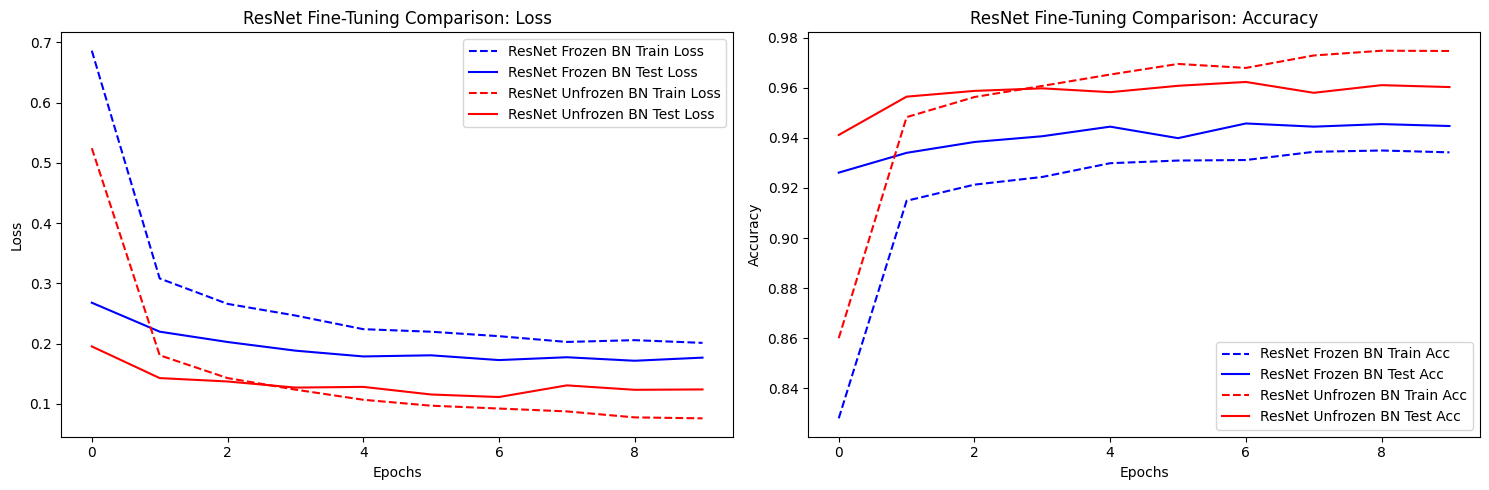

Final ResNet Confusion Matrix:


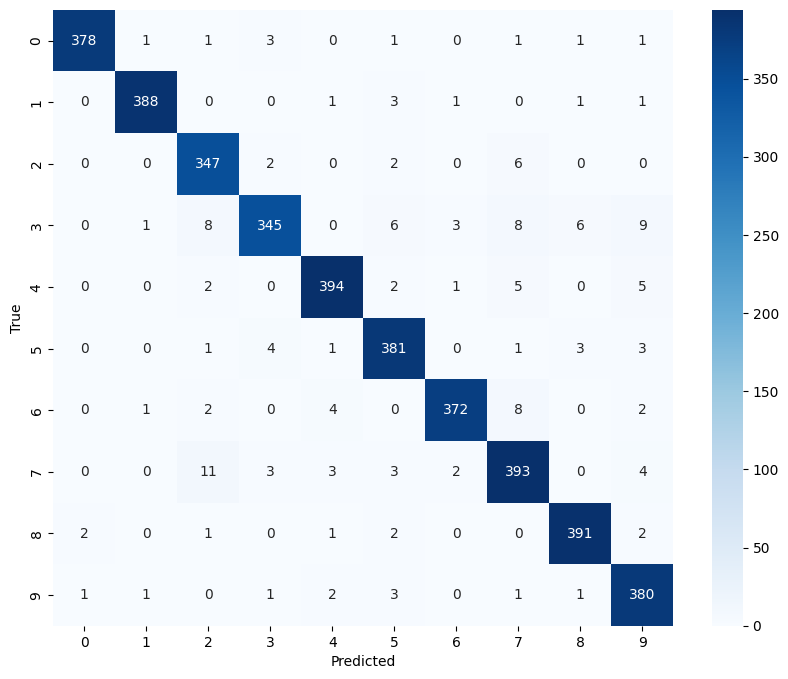

In [21]:
def plot_comparison(stats1, stats2, label1, label2, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # --- 1. LOSS CURVES ---
    ax1.plot(stats1['train_loss'], '--', color='blue', label=f'{label1} Train Loss')
    ax1.plot(stats1['test_loss'], '-', color='blue', label=f'{label1} Test Loss')
    ax1.plot(stats2['train_loss'], '--', color='red', label=f'{label2} Train Loss')
    ax1.plot(stats2['test_loss'], '-', color='red', label=f'{label2} Test Loss')
    ax1.set_title(f'{title}: Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # --- 2. ACCURACY CURVES ---
    ax2.plot(stats1['train_acc'], '--', color='blue', label=f'{label1} Train Acc')
    ax2.plot(stats1['test_acc'], '-', color='blue', label=f'{label1} Test Acc')
    ax2.plot(stats2['train_acc'], '--', color='red', label=f'{label2} Train Acc')
    ax2.plot(stats2['test_acc'], '-', color='red', label=f'{label2} Test Acc')
    ax2.set_title(f'{title}: Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# --- THE MISSING PART: ACTUALLY CALLING THE PLOTS ---

# 1. Plot the curves first
plot_comparison(stats_resnet_frozen, stats_resnet_unfrozen_bn,
                "ResNet Frozen BN", "ResNet Unfrozen BN",
                "ResNet Fine-Tuning Comparison")

# 2. Plot final Confusion Matrix
print("Final ResNet Confusion Matrix:")
plot_confusion_matrix(model_resnet_unfrozen_bn, test_loader)